<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# install necessary modules
!pip install yfinance
!pip install plotly
!pip install ta

In [27]:
import os, time
import yfinance as yf
import requests
import numpy as np
import math
import time

from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt

from ta.trend import MACD
from ta.momentum import StochasticOscillator
from ta.momentum import RSIIndicator


from tabulate import tabulate

In [28]:
  INFO = 1
  DEBUG = 2
  TRACE = 3
  print_level = DEBUG 
  nr_of_features = 1
  look_forward = 1
  epochs = 120
  learning_rate=0.0042

  np.random.seed(42)
  
  look_back = 14 #  number of past days we want to use to predict 1 day in the future.
  split_percent = 0.90 # use 90% of the data  for train

  if look_back < 5:
    num_prediction = look_back * 4
  else:
    num_prediction = look_back * 2


In [29]:
def get_stock_price(ticker, from_date):
  df = yf.download(ticker.ticker, start=from_date, interval="1d")
  #df = df.rename(columns={"Close": "Close1", "Adj Close": "Close"})
  
  #ticker = yf.Ticker(symbol)

  #df = ticker.history(start=from_date, interval="1d")
  #print(df.info())
  df['Date'] = pd.to_datetime(df.index)
  #df['Date'] = df['Date'].apply(mpl_dates.date2num)
  #df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  df['MA21'] = df['Close'].ewm(span=21, adjust=False).mean()
  df['MA50'] = df['Close'].rolling(window=50).mean()
  df['MA100'] = df['Close'].rolling(window=100).mean()
  df['MA200'] = df['Close'].rolling(window=200).mean()
  return df

def is_support(df,i):
  cond1 = df['Low'][i] < df['Low'][i-1] 
  cond2 = df['Low'][i] < df['Low'][i+1] 
  cond3 = df['Low'][i+1] < df['Low'][i+2] 
  cond4 = df['Low'][i-1] < df['Low'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_resistance(df,i):
  cond1 = df['High'][i] > df['High'][i-1] 
  cond2 = df['High'][i] > df['High'][i+1] 
  cond3 = df['High'][i+1] > df['High'][i+2] 
  cond4 = df['High'][i-1] > df['High'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_far_from_level(value, levels, df):
    ave =  np.mean(df['High'] - df['Low'])
    return np.sum([abs(value - level) < ave for level in levels]) == 0

def findNearestGreaterThan(searchVal, inputData):
    diff = inputData - searchVal
    diff[diff<0] = np.inf
    idx = diff.argmin()
    return inputData[idx]


def findNearestLessThan(searchVal, inputData):
    diff = inputData - searchVal
    diff[diff>0] = -np.inf
    idx = diff.argmax()
    return inputData[idx]

def indicators(chart_df):
  # MACD
  macd = MACD(close=chart_df['Close'], 
            window_slow=26,
            window_fast=12, 
            window_sign=9)
  # stochastics
  stoch = StochasticOscillator(high=chart_df['High'],
                             close=chart_df['Close'],
                             low=chart_df['Low'],
                             window=14, 
                             smooth_window=3)

  rsi = RSIIndicator(close=chart_df['Close'], window=14)
  return macd, stoch, rsi

In [30]:
def calculate_levels(chart_df,close_price):
  levels = []
  low = 0
  high = np.round(chart_df['Close'].max(),1)
  for i in range(2,len(chart_df)-2):
    try:
      if is_support(chart_df,i):
        low = chart_df['Low'][i]
      if is_far_from_level(low, levels, chart_df):
        levels.append(low)
      elif is_resistance(chart_df,i):
        high = chart_df['High'][i]
      if is_far_from_level(high, levels, chart_df):
        levels.append(high)
    except Error:
      print('error')
  levels = sorted(levels, reverse=True)

  min_level = np.round(findNearestLessThan(close_price,levels),1)
  if(min_level > close_price):
    min_level = np.round(close_price * 0.8,1)

  max_level = np.round(findNearestGreaterThan(close_price,levels),1)
  if(max_level < close_price):
    max_level = np.round(close_price * 1.2,1)

#  print('close_price',close_price,'min_level:',min_level,'max_level:', max_level)
  return levels, min_level, max_level

In [31]:
def options_chain(ticker):

    #tk = yf.Ticker(symbol)
    # Expiration dates
    exps = ticker.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = ticker.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expirationDate'] = e
        options = options.append(opt, ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options['expirationDate'] = pd.to_datetime(options['expirationDate'])
    options.insert(0,'dte',(options['expirationDate'] - datetime.today()).dt.days + 1)
    options['expirationDate'] = options['expirationDate'].dt.date
    # Boolean column if the option is a CALL x : True if (x > 10 and x < 20) else False
    options.insert(1,'CALL',options['contractSymbol'].str[4:].apply(lambda x: "C" in x))
    
    options[['bid', 
             'ask', 
             'strike', 
             'lastPrice', 
             'volume',
             'change',
             'percentChange',
             'openInterest',
             'impliedVolatility']] = options[[
                                   'bid', 
                                   'ask', 
                                   'strike',
                                   'lastPrice',
                                   'volume',
                                   'change',
                                   'percentChange',
                                   'openInterest',
                                   'impliedVolatility']].apply(pd.to_numeric)
    
    options['spread%'] = np.round(100 - ((options['bid'] / options['ask']) * 100),1) # Calculate the midpoint of the bid-ask
    
    # Drop unnecessary and meaningless columns
    #options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])

    return options

In [32]:
def find_level_optionInterests(ticker,close_price,min_level,max_level, dte_min, dte_max):
  options_df = options_chain(ticker)
  options_df['impliedVolatility'] = np.round(options_df['impliedVolatility'],2)
  options_df['percentChange'] = np.round(options_df['percentChange'],2)
  #expirationDates = options_df['expirationDate'].unique()
  #print(sorted(expirationDates))

  #PUT_options_df = pd.DataFrame()
  #CALL_options_df = pd.DataFrame()

  #for key, value in options_df.items():
  #  date = key
  #  rsi = float(value.get('RSI'))
  #  rsi_data.append([date,rsi])
#  print('PUT OPTIONS', 'CLOSE PRICE:',close_price, 'SUPPORT -15%:', np.round(min_level * 0.85,2), 'RESISTANCE +15%:', np.round(max_level * 1.15,2))
  PUT_options_df = options_df.query('CALL == False and strike>' + str(min_level * 0.85) + ' and strike<' + str(max_level * 1.15) + ' and dte>' + str(dte_min) + ' and dte<' + str(dte_max))
  put_max_openInterest_index = PUT_options_df["openInterest"].idxmax()
  put_max_volume_index = PUT_options_df["volume"].idxmax()
  PUT_options_to_return_df = PUT_options_df.loc[put_max_openInterest_index:put_max_openInterest_index]
  PUT_options_to_return_df = PUT_options_to_return_df.append(PUT_options_df.loc[put_max_volume_index:put_max_volume_index])
  PUT_options_to_return_df = PUT_options_to_return_df.drop(columns = ['contractSize', 'currency','change','percentChange', 'lastTradeDate', 'lastPrice', 'inTheMoney','contractSymbol']) 
  
#  print(tabulate(PUT_options_to_return_df, headers = 'keys', tablefmt = 'psql'))

#  print('CALL OPTIONS', 'CLOSE PRICE:',close_price, 'SUPPORT -15%:', np.round(min_level * 0.85,2), 'RESISTANCE +15%:', np.round(max_level * 1.15,2))
  CALL_options_df = options_df.query('CALL == True and strike>' + str(min_level * 0.85) + ' and strike<' + str(max_level * 1.15) + ' and dte>' + str(dte_min) + ' and dte<' + str(dte_max))
  call_max_openInterest_index = CALL_options_df["openInterest"].idxmax()
  call_max_volume_index = CALL_options_df["volume"].idxmax()
  CALL_options_to_return_df = CALL_options_df.loc[call_max_openInterest_index:call_max_openInterest_index]
  CALL_options_to_return_df = CALL_options_to_return_df.append(CALL_options_df.loc[call_max_volume_index:call_max_volume_index])
  CALL_options_to_return_df = CALL_options_to_return_df.drop(columns = ['contractSize', 'currency', 'change','percentChange', 'lastTradeDate', 'lastPrice', 'inTheMoney','contractSymbol']) 
#  print(call_max_openInterest_index,tabulate(CALL_options_to_return_df, headers = 'keys', tablefmt = 'psql'))
  return PUT_options_to_return_df, CALL_options_to_return_df

In [40]:
def get_chart(ticker, df, prediction_data, forecast_data):
  days = 365
  last_day_df = df[-1:]
  last_date = last_day_df['Date'].index[0].date()
  close_price = np.round(last_day_df['Close'][0],1)

  ath = np.round(df['Close'].max(),1)
  discount = np.round(ath - close_price,1)
  discount_percent = np.round((discount / close_price) * 100, 1)
  
  chart_df = df.tail(days)

  levels, min_level, max_level = calculate_levels(chart_df,close_price)


#  indicators_forecast_dates = predict_dates(last_date,num_prediction)
#  df1 = pd.DataFrame(
#    indicators_forecast_dates, 
#    columns = ['Date']) 

#  chart_df = chart_df.append(df1, ignore_index=True)

  min_level_0_85 = np.round(min_level * 0.85,2)
  min_level_0_85_discount = np.round(min_level_0_85 - close_price)
  min_level_0_85_discount_percent =  np.round((min_level_0_85_discount / close_price) * 100, 1)

  max_level_1_15 = np.round(max_level * 1.15,2)
  max_level_1_15_discount = np.round(max_level_1_15 - close_price)
  max_level_1_15_discount_percent = np.round((max_level_1_15_discount / close_price) * 100, 1)

  options_df = pd.DataFrame()
  near_PUT_options_df, near_CALL_options_df = find_level_optionInterests(ticker,close_price,min_level_0_85,max_level_1_15, -1, 33)
  far_PUT_options_df, far_CALL_options_df = find_level_optionInterests(ticker,close_price,min_level_0_85,max_level_1_15, 33, 333)

  options_df = options_df.append(near_PUT_options_df)
  options_df = options_df.append(far_PUT_options_df)
  options_df = options_df.append(near_CALL_options_df)
  options_df = options_df.append(far_CALL_options_df)
  options_df.insert(3,'Price',close_price)
  options_df = options_df.sort_values(by=['dte'])

  min_level_discount = np.round(min_level - close_price)
  min_level_discount_percent = np.round((min_level_discount / close_price) * 100, 1)
  
  max_level_discount = np.round(max_level - close_price)
  max_level_discount_percent = np.round((max_level_discount / close_price) * 100, 1)
  
  tradingview_link = '<a href="https://in.tradingview.com/chart/66XmQfYy/?symbol=' + ticker.ticker +'">' +  ticker.ticker + ' ' + str(last_date)  +'</a> '
  seeking_alpha_link = '<a href="https://seekingalpha.com/symbol/'+ ticker.ticker +'"> Seeking Alpha </a> '
  google_news_link = '<a href="https://news.google.com/search?for=' + ticker.ticker + '+stock when:7d&hl=en-US&gl=US&ceid=US%3Aen"> Google News </a> '
  twitter_link = '<a href="https://twitter.com/search?q=$' + ticker.ticker + '%20stock&src=typed_query&f=live"> Twitter </a> '

  title = '<b>' + tradingview_link + '</b> ' + seeking_alpha_link + google_news_link + twitter_link 
  title += '<br>'
  title += '<b>Close Price:</b>' + str(close_price) + ' <b>ATH:</b>' + str(ath) + ' <b>Discount:</b>' + str(discount) + ' (' + str(discount_percent) + '%)'
  title += '<br>'
  title += '<b>Support:</b>' + str(min_level) + ' ('+str(min_level_discount_percent)+'%) ' 
  title += '<b>Close Price:</b>' + str(close_price) + ' ' 
  title += '<b>Resistance:</b>' + str(max_level) + ' ('+str(max_level_discount_percent)+'%) '
  title += '<br>' 
  title += '<b>Support -15%:</b>' + str(min_level_0_85) + ' (' + str(min_level_0_85_discount_percent) + '%) '
  title += '<b>Close Price:</b>' + str(close_price) + ' ' 
  title += '<b>Resistance +15%:</b>' + str(max_level_1_15) + ' (' + str(max_level_1_15_discount_percent) +  '%) '
  
  # add subplot properties when initiliazing fig variable
  fig = make_subplots(rows=5, cols=1, shared_xaxes=True,
                    vertical_spacing=0.01, 
                    row_heights=[0.26,0.34,0.1,0.15,0.15],
                    subplot_titles=[title],
                    specs=[
                           [{"type": "table"}],
                           [{"type": "candlestick"}],
                           [{"type": "bar"}],
                           [{"type": "scatter"}],
                           [{"type": "scatter"}]
                           ])

  fig.update_layout(
      height=900, width=1200, 
      showlegend=True,
      dragmode= 'pan', 
      margin=go.layout.Margin(
          l=20, #left margin
          r=20, #right margin
          b=20, #bottom margin
          t=100  #top margin
      ))


  fig.add_trace(
      go.Table(
        header=dict(values=list(options_df.columns),
                fill_color='paleturquoise',
                font=dict(color='black', size=12),
                align='left'),
        cells=dict(values=options_df.transpose().values.tolist(),
               fill_color='lavender',
               align='left')
        ),row=1, col=1)
  
  # Plot OHLC on 1st subplot (using the codes from before)
  fig.add_trace(go.Candlestick(x=chart_df.index,
                             open=chart_df['Open'],
                             high=chart_df['High'],
                             low=chart_df['Low'],
                             close=chart_df['Close'], 
                             name=ticker.ticker,
                             showlegend=True), row=2, col=1)
  

  # add moving average traces
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA21'], 
                         line=dict(color='green', width=2), 
                         name='MA 21'), row=2, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA50'], 
                         line=dict(color='blue', width=2), 
                         name='MA 50'), row=2, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA100'], 
                         line=dict(color='orange', width=2), 
                         name='MA 100'), row=2, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index, 
                         y=chart_df['MA200'], 
                         line=dict(color='red', width=2), 
                         name='MA 200'), row=2, col=1)


  start_date = "2021-06-01"
  end_date = "2022-01-31"
  #zoom_df = chart_df.iloc['Date' >= start_date]
  
  zoom_df = chart_df[chart_df.Date >= start_date]
  y_zoom_max = zoom_df["High"].max()
  y_zoom_min = zoom_df["Low"].min()

  ath_percent = 0
  
  for idx, level in  enumerate(levels):
      percent = 0
      if idx == 0:
        ath = level
      current_level = level
      if idx > 0:
        prev_level = levels[idx-1]
        diff = prev_level - current_level
        ath_diff = ath - current_level
        percent = (diff / current_level) * 100
        ath_percent =  (ath_diff / current_level) * 100
      if level <= (min_level * 0.85) or level >= (max_level * 1.15):
        line_color = 'rgba(100, 10, 100, 0.2)'
      else:
        line_color = 'rgba(200, 20, 200, 1)'
      fig.add_trace(go.Scatter(
          x = [chart_df.index.min(), chart_df.index.max()],
          y = [level, level],
          mode="lines+text",
          name="Lines and Text",
          showlegend=False,
          text=['','$' + str(np.round(current_level,1)) + ' (' + str(np.round(percent,1)) + '% disc:' + str(np.round(ath_percent,1))+ '%)',''],
          textposition="top right",
          line = dict(shape = 'linear', color = line_color, dash = 'dash', width=1)
        ), row=2, col=1)


  # Plot volume trace on 3d row 
  colors = ['green' if row['Open'] - row['Close'] >= 0 
            else 'red' for index, row in chart_df.iterrows()]
  fig.add_trace(go.Bar(x=chart_df.index, 
                      y=chart_df['Volume'],
                      marker_color=colors,
                      name='Volume'
                      ), row=3, col=1)

  print('min',np.min(chart_df.index))
  fig.add_trace(go.Scatter(x=chart_df.index,
                          y=chart_df['RSI'],
                          line=dict(color='black', width=2),
                          name='RSI(14)'
                          ), row=4, col=1)

  fig.add_trace(go.Scatter(x=chart_df['Date'].tail(len(prediction_data)),
                          y = prediction_data,
                          line=dict(color='red', width=2),
                          name='RSI(14)'
                          ), row=4, col=1)
  
  indicators_forecast_dates = predict_dates(last_date)

  fig.add_trace(go.Scatter(x=indicators_forecast_dates,
                          y = forecast_data,
                          line=dict(color='green', width=2),
                          name='RSI(14)'
                          ), row=4, col=1)
 

  fig.add_trace(go.Scatter(
          x = [np.min(chart_df.index), np.max(chart_df.index)],
          y = [70, 70],
          mode = "lines",
          line = dict(shape = 'linear', color = 'rgb(100, 10, 100)', dash = 'dash'),
          name = 'RSI(14) over bought'
      ),row=4, col=1)

  fig.add_trace(go.Scatter(
          x = [np.min(chart_df.index), np.max(chart_df.index)],
          y = [50, 50],
          mode = "lines",
          line = dict(shape = 'linear', color = 'rgb(10, 12, 240)', dash = 'dash'),
          name='RSI(14) Neutral'
      ),row=4, col=1)

  fig.add_trace(go.Scatter(
          x = [np.min(chart_df.index), np.max(chart_df.index)],
          y = [30, 30],
          mode = "lines",
          line = dict(shape = 'linear', color = 'rgb(10, 120, 24)', dash = 'dash'),
          name='RSI(14) over sold'
      ),row=4, col=1)

  # Plot MACD trace on 3rd row
  colors = ['green' if val >= 0 
            else '#FF5733' for val in macd.macd_diff()]
  fig.add_trace(go.Bar(x=chart_df.index, 
                      y=chart_df['MACD_DIFF'],
                      marker_color=colors,
                      name='MACD diff'
                      ), row=5, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index,
                          y=chart_df['MACD'],
                          line=dict(color='orange', width=2),
                          name='MACD'
                          ), row=5, col=1)
  fig.add_trace(go.Scatter(x=chart_df.index,
                          y=chart_df['MACD_SIGNAL'],
                          line=dict(color='blue', width=1),
                          name='MACD signal'
                          ), row=5, col=1)


  fig.update_xaxes(type="date", range=[start_date, end_date])
  fig.update_yaxes(range=[y_zoom_min,y_zoom_max], row=2, col=1)

#  for idx, level in  enumerate(levels):
#    fig.add_hline(level,row=2, col=1)

  fig.update_layout(xaxis_rangeslider_visible=False)
  # removing all empty dates
  # build complete timeline from start date to end date
#  dt_all = pd.date_range(start=chart_df.index[0],end=chart_df.index[-1])
  # retrieve the dates that ARE in the original datset
#  dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(chart_df.index)]
  # define dates with missing values
#  dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]

#  fig.update_layout(xaxis_rangebreaks=[dict(values=dt_breaks)])
  fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
  fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')
  config = dict({'scrollZoom': True})

  folder='/content/drive/MyDrive/models/charts/'+ str(last_date)
  Path(folder).mkdir(parents=True, exist_ok=True)
  #print('chart folder:', folder)
  fig.write_html(folder + '/' + ticker.ticker + '.html') 
  return fig

In [34]:
def predict(indicators_lstm_test_data_scaled, model):
    prediction_list = indicators_lstm_test_data_scaled[-look_back:]
    #print('prediction_list',prediction_list)
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        #print(x)
        x = x.reshape((1, look_back, nr_of_features))
        out = model.predict(x)
        #print(x,out) 
        prediction_list = np.append(prediction_list, out, axis=0)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(last_date):
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1,freq=us_bd).tolist()
    return prediction_dates

In [35]:
def get_prediction_data(df,ticker):

  indicators_model_file_path = '/content/drive/MyDrive/models/' + ticker.ticker + '_' + str(look_back) + '_' + str(nr_of_features) + '_indicators_10.h5'
  
  indicators_model = None
  try:
    indicators_model = keras.models.load_model(indicators_model_file_path)
    #modified = os.path.getmtime(indicators_model_file_path)

    #print(pd.to_datetime(last_date).date() - datetime.fromtimestamp(modified).date() )
    #print('Loaded', indicators_model_file_path , ' model train date:',datetime.fromtimestamp(modified).date() , 'last date:', last_date)
  except:
    indicators_model = None
    print('Model ' + indicators_model_file_path + ' does not exists.')

  indicators_lstm_data = np.expand_dims(df['RSI'].values.copy()[look_back:], axis=1).astype(float)
  split = int(split_percent*len(indicators_lstm_data))
 
  indicators_scaler = MinMaxScaler(feature_range=(0, 1))
  indicators_scaler = indicators_scaler.fit(indicators_lstm_data)

  indicators_lstm_train_data = indicators_lstm_data[:split]
  indicators_lstm_test_data = indicators_lstm_data[split:]
  
  indicators_lstm_train_data_scaled = indicators_scaler.transform(indicators_lstm_train_data)
#  print(indicators_lstm_train_data_scaled[:look_back*2])
#  print(indicators_lstm_train_data_scaled.shape)
  
  indicators_lstm_test_data_scaled = indicators_scaler.transform(indicators_lstm_test_data)
#  print(indicators_lstm_test_data_scaled[:look_back+1])
#  print(indicators_lstm_test_data_scaled.shape)

  indicators_train_generator = TimeseriesGenerator(indicators_lstm_train_data_scaled, indicators_lstm_train_data_scaled, sampling_rate=1, length=look_back, batch_size=64)

  if indicators_model is None:
    indicators_model = Sequential()
    indicators_model.add(LSTM(units=42, activation='tanh', input_shape=(look_back, nr_of_features), return_sequences=True))
    indicators_model.add(Dropout(0.2))
    indicators_model.add(LSTM(units=42, return_sequences=True, activation="relu"))
    indicators_model.add(Dropout(0.2))
    indicators_model.add(LSTM(units=42, return_sequences=True, activation="relu"))
    indicators_model.add(Dropout(0.2))
    indicators_model.add(LSTM(units=42, activation="tanh"))
    indicators_model.add(Dropout(0.2))
    indicators_model.add(Dense(nr_of_features))

    indicators_model.compile(
      loss=MAE,
      optimizer=Adam(learning_rate=learning_rate),
      metrics=['mae','mse']
    )
    
    #indicators_model.summary()
    print('Model ' + indicators_model_file_path + ' compiled.')

    indicators_modelo = indicators_model.fit(indicators_train_generator, epochs=epochs, verbose=0 )
  
    #indicators_model.save(indicators_model_file_path)
    #print('Saved model ' + indicators_model_file_path)

  
    plt.plot(indicators_modelo.history['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

  indicators_test_generator = TimeseriesGenerator(indicators_lstm_test_data_scaled, indicators_lstm_test_data_scaled,sampling_rate=1, length=look_back, batch_size=look_back)
  #Make prediction
  indicators_prediction_scaled = indicators_model.predict(indicators_test_generator)

  indicators_prediction = indicators_scaler.inverse_transform(indicators_prediction_scaled)
  rsi_prediction = indicators_prediction.reshape((-1))


  indicators_forecast_scaled = predict(indicators_lstm_test_data_scaled, indicators_model)
  #print(forecast_scaled)

  indicators_forecast = indicators_scaler.inverse_transform(indicators_forecast_scaled.reshape((-1,nr_of_features)))
  rsi_forecast = indicators_forecast.reshape((-1))

  return rsi_prediction, rsi_forecast

[*********************100%***********************]  1 of 1 completed
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date', 'MA21', 'MA50', 'MA100', 'MA200']
Model /content/drive/MyDrive/models/ARKG_14_1_indicators_10.h5 does not exists.
Model /content/drive/MyDrive/models/ARKG_14_1_indicators_10.h5 compiled.


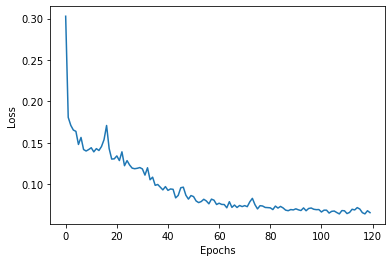

[33.46934873 38.34610365 40.37523597 41.88462532 42.79160222 43.38882621
 43.86259777 44.1797136  44.3084747  44.23393302 44.02938457 43.72130713
 43.45182723 43.26671233 43.16167177 43.13517033 43.16295751 43.22077006
 43.28943123 43.35426434 43.40535137 43.43695751 43.44837979 43.44321317
 43.42732178 43.40660978 43.38654977 43.37069844 43.36068391]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: RuntimeWarning:

divide by zero encountered in double_scalars



min 2020-07-30 00:00:00


In [41]:
ticker = yf.Ticker('ARKG')
df = get_stock_price(ticker,"2019-01-01")
print(list(df.columns))

macd, soch, rsi = indicators(df)
df['RSI'] = rsi.rsi().to_numpy()
df['MACD_DIFF'] = macd.macd_diff().to_numpy()
df['MACD'] = macd.macd().to_numpy()
df['MACD_SIGNAL'] = macd.macd_signal().to_numpy()

prediction_data, forecast_data = get_prediction_data(df,ticker)
#print(prediction_data)
print(forecast_data)
fig = get_chart(ticker, df,prediction_data, forecast_data)
fig.show()

In [37]:
def save_charts(symbols):
  for symbol in symbols:
    ticker = yf.Ticker(symbol)
    df = get_stock_price(ticker,"2019-01-01")
    print(ticker.ticker,df.size)
    get_chart(ticker, df, 365)
    #time.sleep(5)
  return None

In [38]:
symbols = ['AAPL','AMD','AMZN','ABBV','ARKG','ARKK','ARKQ','ATVI',
           'BA','CAT','CCL','CHPT','CHWY','COIN','CRM','DDOG',
           'DIA','DIS','DKNG','DOCU','EA','ETSY','FB','GOOGL','HOG']

symbols1 = ['HOOD','HUT','IWM','JAZZ','JETS','LVS','MA','MP',
           'MRNA','MSFT','MSTR','MU','NCLH','NFLX','NKE','NNDM','NVDA']

symbols2 = ['PFE','PINS','PLTR','PYPL','QQQ','RBLX','SPY',
           'ROKU','SBUX','SHOP','SNAP','SOFI','SOXL','SOXX','SPY','SQ']

symbols3 = ['TDOC','TEN','TGT','TLT','TSLA','TTD','TWTR','UAA',
           'V','VTI','WBA','VALE','WMT','WYNN','XLE','XLF','XLNX','ZM']

symbols4 = ['COST','RIVN','U','PENN','QCOM','RKLB','LCID','ASTR','BNGO','AAL','UBER','FRM']

#save_charts(symbols)
#save_charts(symbols1)
#save_charts(symbols2)
#save_charts(symbols3)
#save_charts(symbols4)